# Statistical Deep Learning Project: Fashion Mnist Dataset

## 1. Introduction
The Fashion MNIST dataset is a widely-used in the field of deep learning. It serves as an alternative to the traditional MNIST dataset, focusing on fashion items and clothing accessories. The objective of this project is to leverage the Fashion MNIST dataset as a means to explore, develop, and evaluate deep learning models, especially Convolutional Neural Network, for image classification tasks, with a specific focus on classifying fashion items. This report provides an overview of the Fashion MNIST dataset and practical applications.

## 2. Dataset Description

### 2.1 Importing Libraries

In [136]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

### 2.2 Importing Data

In [137]:

# Load the Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Split the dataset into training, validation, and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print (f'The shape of X_train: {X_train.shape}')
print (f'The shape of y_train: {y_train.shape}')

print (f'The shape of X_valid: {X_valid.shape}')
print (f'The shape of y_valid: {y_valid.shape}')

print (f'The shape of X_test: {X_test.shape}')
print (f'The shape of y_test: {y_test.shape}')

The shape of X_train: (48000, 28, 28)
The shape of y_train: (48000,)
The shape of X_valid: (12000, 28, 28)
The shape of y_valid: (12000,)
The shape of X_test: (10000, 28, 28)
The shape of y_test: (10000,)


The dataset comprises a total of 70,000 images, which are divided into 60,000 images for training and 10,000 images for testing. Each image is composed of 28 pixels in both height and width, resulting in a total of 784 pixels for each image. 

In order to facilitate model training and evaluation, the training dataset was divided into a training set and a validation set. Approximately 20% of the training data was allocated to the validation set, ensuring a balance between model training and evaluation.

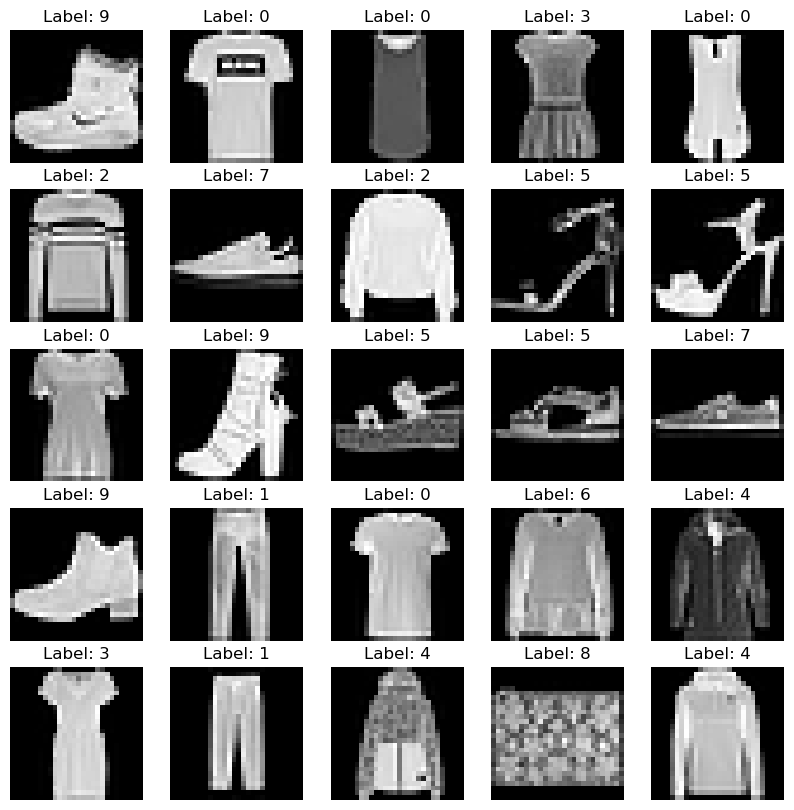

In [138]:
# Visualize a few samples from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_full[i], cmap='gray')
    plt.title(f'Label: {y_train_full[i]}')
    plt.axis('off')
plt.show()


### 2.3 Explore Data

In [139]:
# Get the unique labels in the training dataset
unique_labels = np.unique(y_train_full)

# Print the unique labels
print("Unique labels in the training dataset:", unique_labels)
print("Number of unique labels:", len(unique_labels))

Unique labels in the training dataset: [0 1 2 3 4 5 6 7 8 9]
Number of unique labels: 10


The class names are well-defined for the Fashion MNIST dataset and are as follows:

0: T-shirt/top

1: Trouser

2: Pullover

3: Dress

4: Coat

5: Sandal

6: Shirt

7: Sneaker

8: Bag

9: Ankle boot

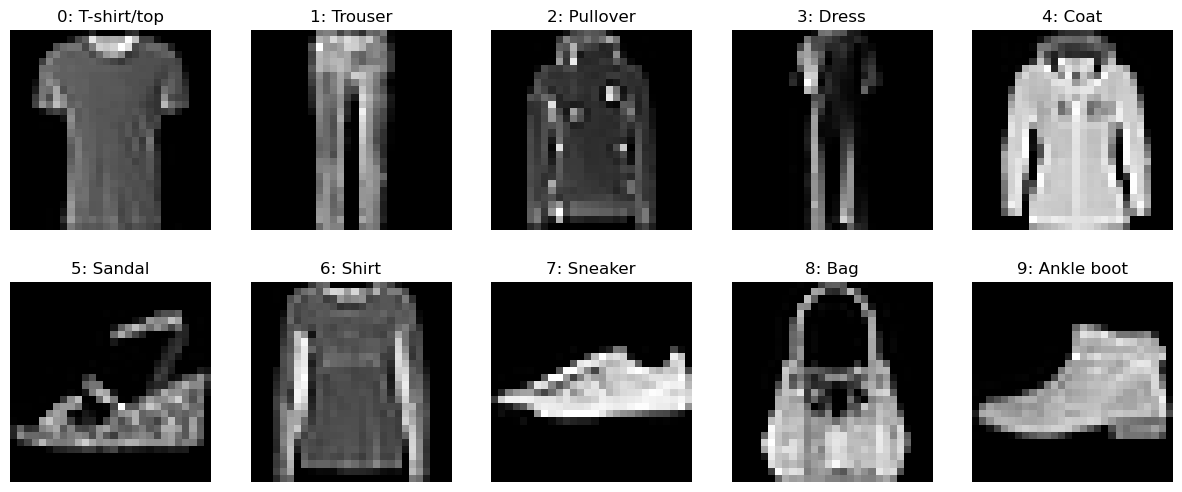

In [131]:
# Define class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a dictionary to store one sample for each class
samples_by_class = {class_name: None for class_name in class_names}

# Collect one sample for each class
for i in range(len(y_train)):
    label = y_train[i]
    class_name = class_names[label]
    if samples_by_class[class_name] is None:
        samples_by_class[class_name] = X_train[i]

# Plot the samples in a 2x5 grid with integer class labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, class_name in enumerate(class_names):
    label = i
    ax = axes[i // 5, i % 5]
    ax.imshow(samples_by_class[class_name], cmap='gray')
    ax.set_title(f'{label}: {class_name}')
    ax.axis('off')

plt.show()


## 3. Data Preprocessing

### 3.1 Normalization

In [140]:
# Normalize pixel values to a range of 0 to 1
def normalize(data):
    data_normalized = data.astype(np.float64) / 255
    return data_normalized

X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

Normalization is a critical preprocessing step for image data. First, the data is converted to a float data type. Then, pixel values are rescaled to fit within the range of 0 to 1. This ensures that the data is standardized and ready for deep learning models.

### 3.2 Check Imbalancing

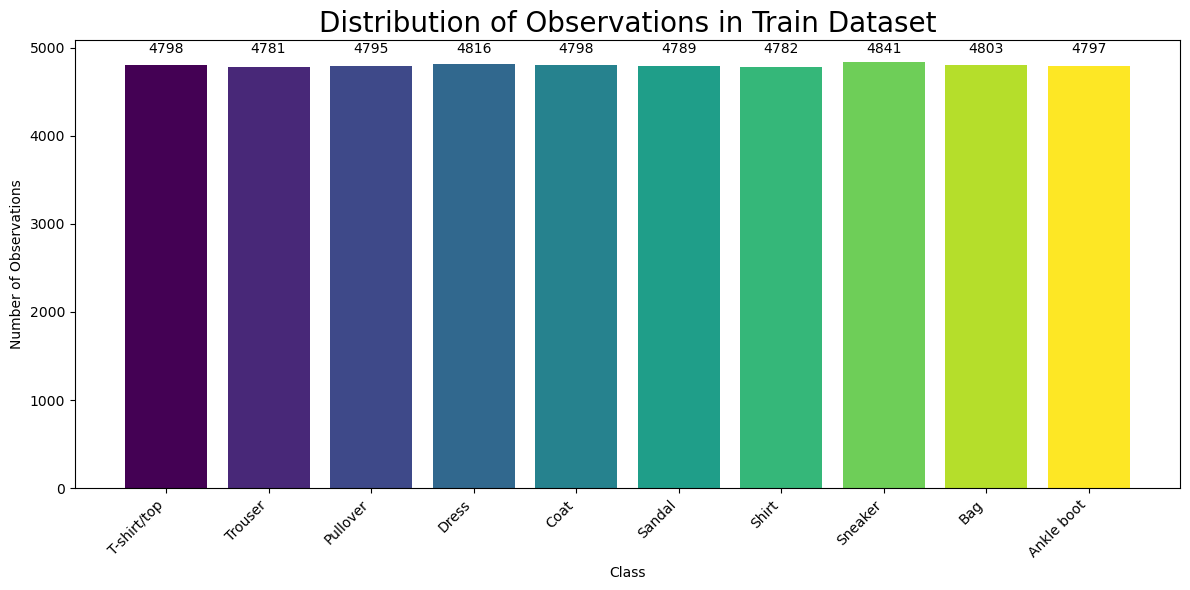

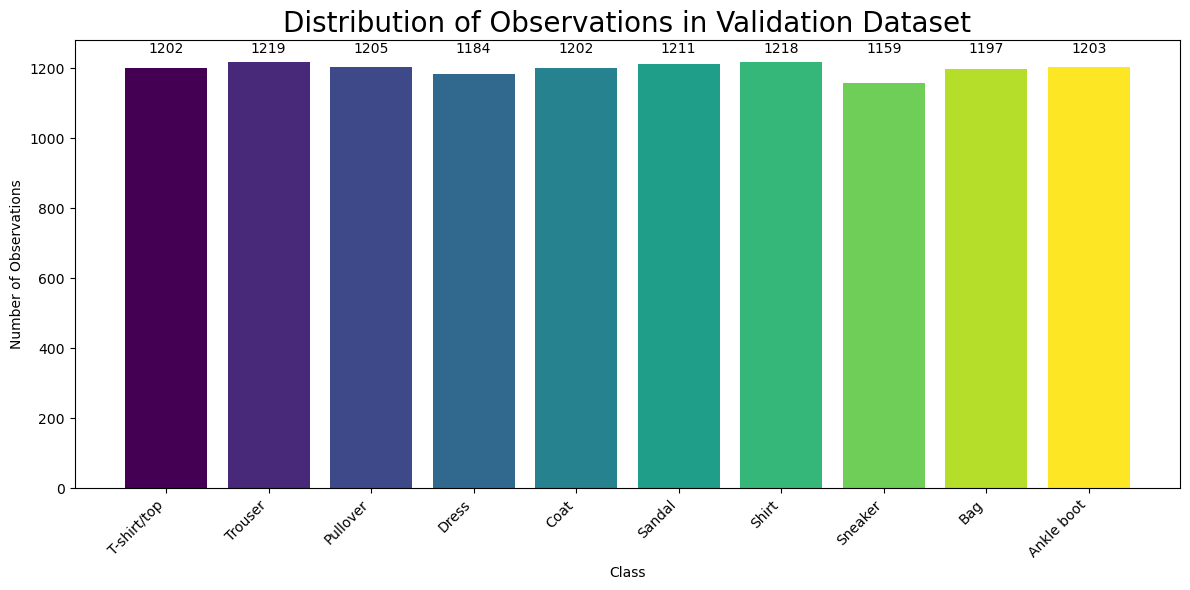

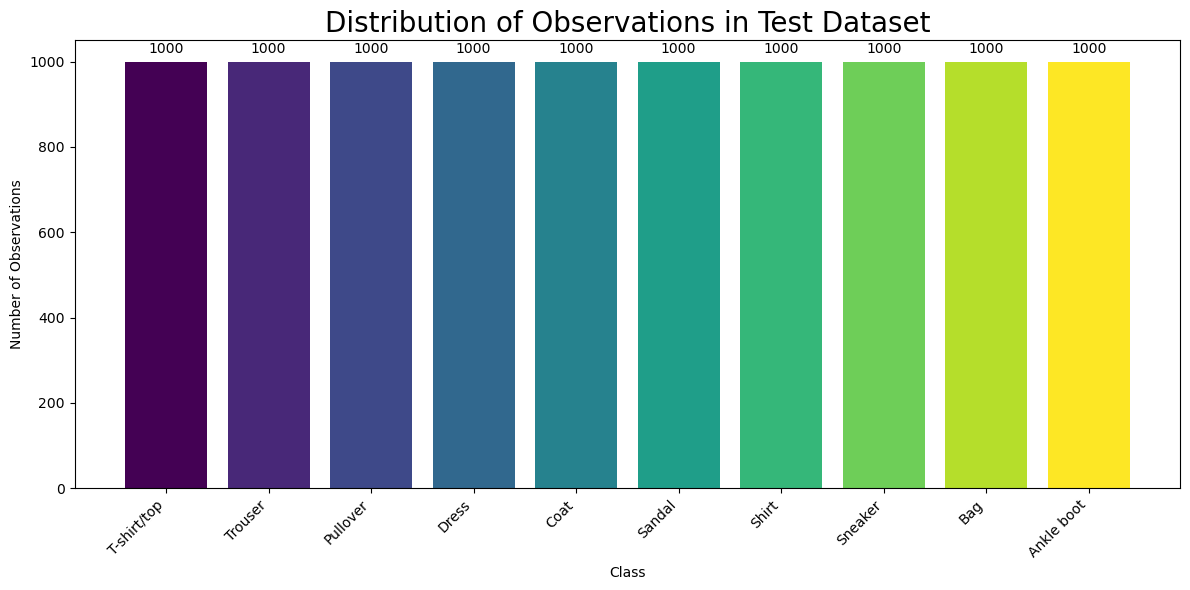

In [141]:
def plot_class_distribution(data, class_names, dataset_name):
    # Create a list to store the counts of observations for each class
    class_counts = [0] * len(class_names)

    # Count the observations in the provided dataset
    for label in data:
        class_counts[label] += 1

    # Define a color map for the bars
    colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))

    # Plot the histogram
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
    bars = ax.bar(class_names, class_counts, color=colors)
    
    # Calculate the height for count labels and adjust the padding
    max_height = max(class_counts)
    padding = max_height * 0.02
    
    # Set dynamic title and labels based on dataset size
    title = f'Distribution of Observations in {dataset_name}'
    plt.title(title, fontsize=20)

    plt.xlabel('Class')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45, ha='right')
    
    # Add only the count on top of each bar
    for bar, count in zip(bars, class_counts):
        ax.text(bar.get_x() + bar.get_width() / 2, max_height + padding, f'{count}', ha='center')

    plt.tight_layout()
    plt.show()

# Example usage with X_train and y_train
# Assuming X_train, y_train, and class_names are defined
plot_class_distribution(y_train, class_names, 'Train Dataset')
plot_class_distribution(y_valid, class_names, 'Validation Dataset')
plot_class_distribution(y_test, class_names, 'Test Dataset')




## 4. Modeling

For building a model for image classification, I used convolutional neural networks (CNNs). 

My approach involves building a series of CNNs with varying depths and complexity, starting from a basic 2-layer CNN and progressively increasing the number of layers and units. This gradual expansion allows me to find the optimal configuration that achieves the highest validation performance while addressing the challenge of overfitting.

### 4.1 Basic 2-layer CNN

#### 4.1.1 Model Architecture

In [142]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# train_model = model.fit(X_train, y_train, batch_size = 128, epochs=10, validation_data=(X_valid, y_valid))

I started with a basic 2-layer CNN and then increase the layers getting the best validation performance possible. The classification model was built using a Sequential model in Keras. The architecture consists of the following layers:

* Convolutional layers with 32 and 64 filters of size (3, 3) and ReLU activation functions.
* Max-pooling layers with (2, 2) pooling windows.
Flattening layer to transform the 2D feature maps into a 1D vector.
* Two fully connected (Dense) layers with 128 units and ReLU activation, and an output layer with 10 units and softmax activation for classification.

#### 4.1.2 Model Training and Cross-validation

In [143]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical


# Step 4: K-fold cross-validation on the training set
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold = 0
scores = []

for train_ix, test_ix in skf.split(X_train, y_train):
    fold += 1
    print(f"Fold {fold}")

    X_train_fold, X_test_fold = X_train[train_ix], X_train[test_ix]
    y_train_fold, y_test_fold = y_train[train_ix], y_train[test_ix]
    
    # Train the model on X_train_fold and y_train_fold
    train_model = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=128, validation_data=(X_valid, y_valid), verbose=1)
    
    # Step 5: Model evaluation on the validation set
    loss1, accuracy1 = train_model.model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Validation Loss: {loss1:.4f}")
    print(f"Validation Accuracy: {accuracy1 * 100:.2f}%")

    scores.append(accuracy1)
    

# Calculate and print the mean accuracy across all folds
mean_accuracy1 = np.mean(scores) * 100.0
print(f"Mean Accuracy: {mean_accuracy1:.2f}%")

Fold 1
Epoch 1/10
300/300 [==============================] - 52s 155ms/step - loss: 0.6058 - accuracy: 0.7862 - val_loss: 0.4109 - val_accuracy: 0.8524
Epoch 2/10
300/300 [==============================] - 41s 136ms/step - loss: 0.3768 - accuracy: 0.8657 - val_loss: 0.3425 - val_accuracy: 0.8765
Epoch 3/10
300/300 [==============================] - 35s 118ms/step - loss: 0.3295 - accuracy: 0.8819 - val_loss: 0.3281 - val_accuracy: 0.8780
Epoch 4/10
300/300 [==============================] - 47s 155ms/step - loss: 0.2946 - accuracy: 0.8934 - val_loss: 0.2988 - val_accuracy: 0.8932
Epoch 5/10
300/300 [==============================] - 35s 118ms/step - loss: 0.2719 - accuracy: 0.9020 - val_loss: 0.2917 - val_accuracy: 0.8947
Epoch 6/10
300/300 [==============================] - 37s 124ms/step - loss: 0.2521 - accuracy: 0.9076 - val_loss: 0.2946 - val_accuracy: 0.8940
Epoch 7/10
300/300 [==============================] - 37s 124ms/step - loss: 0.2339 - accuracy: 0.9155 - val_loss: 0.2726 -

To ensure model robustness, a 5-fold cross-validation strategy was implemented. Each fold was used for both training and validation, and the following steps were carried out:

* Model training for 10 epochs on the training data for each fold.
* Validation of model performance on the validation set.
* Collection of validation accuracy scores for each fold.

#### 4.1.3 Result

The model was trained and validated using the cross-validation strategy. The validation accuracy for each fold is as follows:

- Fold 1: Validation Accuracy = 90.27% 
- Fold 2: Validation Accuracy = 93.11%
- Fold 3: Validation Accuracy = 94.86%
- Fold 4: Validation Accuracy = 97.52%
- Fold 5: Validation Accuracy = 98.26%


The mean validation accuracy across all folds was calculated and is reported as follows:

- Mean Validation Accuracy: **94.81%**

#### 4.1.4 Loss and Accuracy Plot

In [146]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import numpy as np

def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model)

To visualize the performance of the model during cross-validation, a line plot was created to show the changes in validation accuracy across five folds. The x-axis represents the number of epochs, while the y-axis shows the validation accuracy as a percentage.

However, attention should be paid to potential overfitting, as the training accuracy exceeds the validation accuracy. Further fine-tuning and regularization techniques can be explored to strike a balance between enhanced performance and generalization.

#### 4.1.5 Model Evaluate

In [147]:
# Use the trained model stored in 'train_model' to evaluate it on the test set
evaluation = train_model.model.evaluate(X_test, y_test)

# The `evaluate` method returns a list of evaluation metrics
train_model_loss, train_model_accuracy = evaluation

print(f"Basic CNN Test Loss: {train_model_loss:.4f}")
print(f"Basic CNN Test Accuracy: {train_model_accuracy * 100:.2f}%")

313/313 [==============================] - 4s 13ms/step - loss: 0.5476 - accuracy: 0.9051
Basic CNN Test Loss: 0.5476
Basic CNN Test Accuracy: 90.51%


### 4.2 2-layers CNN with dropout

#### 4.2.1 Model Architecture

In [53]:
model_ = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model_.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# train_model = model.fit(X_train, y_train, batch_size = 128, epochs=10, validation_data=(X_valid, y_valid))

In the pursuit of achieving the best classification performance while mitigating the risk of overfitting, the initial model, a 2-layer CNN, was further refined. The refined model includes the addition of dropout layers, which play a crucial role in regularization.
The architecture consists of:
- All same with the first CNN model
- Add Dropout Layer (Rate: 0.25): Recognizing the risk of overfitting, a dropout layer is inserted after the max-pooling layers. 
- Add Dropout Layer (Rate: 0.5): As a countermeasure against overfitting, a dropout layer with a rate of 0.5 is positioned before the final classification layer. In this setup, 50% of neurons are randomly deactivated during training.

#### 4.2.2 Model Training and Cross-validation

In [59]:
# Step 4: K-fold cross-validation on the training set
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold = 0
scores_dropout = []

for train_ix, test_ix in skf.split(X_train, y_train):
    fold += 1
    print(f"Fold {fold}")

    X_train_fold, X_test_fold = X_train[train_ix], X_train[test_ix]
    y_train_fold, y_test_fold = y_train[train_ix], y_train[test_ix]
    
    # Train the model on X_train_fold and y_train_fold
    train3_model = model_.fit(X_train_fold, y_train_fold, epochs=10, batch_size=128, validation_data=(X_valid, y_valid), verbose=1)
    
    # Step 5: Model evaluation on the validation set
    loss2, accuracy2 = model_.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Validation Loss: {loss2:.4f}")
    print(f"Validation Accuracy: {accuracy2 * 100:.2f}%")

    scores_dropout.append(accuracy2)
    

# Calculate and print the mean accuracy across all folds
mean_accuracy2 = np.mean(scores) * 100.0
print(f"Dropout Mean Accuracy: {mean_accuracy2:.2f}%")

Fold 1
Epoch 1/10
300/300 [==============================] - 44s 145ms/step - loss: 0.4543 - accuracy: 0.8328 - val_loss: 0.3619 - val_accuracy: 0.8650
Epoch 2/10
300/300 [==============================] - 44s 146ms/step - loss: 0.4188 - accuracy: 0.8474 - val_loss: 0.3517 - val_accuracy: 0.8689
Epoch 3/10
300/300 [==============================] - 44s 148ms/step - loss: 0.3935 - accuracy: 0.8581 - val_loss: 0.3207 - val_accuracy: 0.8806
Epoch 4/10
300/300 [==============================] - 43s 141ms/step - loss: 0.3725 - accuracy: 0.8642 - val_loss: 0.3048 - val_accuracy: 0.8866
Epoch 5/10
300/300 [==============================] - 47s 156ms/step - loss: 0.3537 - accuracy: 0.8710 - val_loss: 0.3027 - val_accuracy: 0.8884
Epoch 6/10
300/300 [==============================] - 43s 143ms/step - loss: 0.3372 - accuracy: 0.8770 - val_loss: 0.2851 - val_accuracy: 0.8933
Epoch 7/10
300/300 [==============================] - 44s 146ms/step - loss: 0.3290 - accuracy: 0.8793 - val_loss: 0.2763 -

A 5-fold cross-validation strategy was implemented as well, and all steps were the same with the first CNN model.

#### 4.2.3 Result

The validation accuracy for each fold is as follows:

- Fold 1: Validation Accuracy = 90.02%
- Fold 2: Validation Accuracy = 92.05%
- Fold 3: Validation Accuracy = 92.84%
- Fold 4: Validation Accuracy = 93.97%
- Fold 5: Validation Accuracy = 94.52%

The mean validation accuracy across all folds was calculated and is reported as follows:

- Mean Validation Accuracy: **92.68%**

#### 4.2.4 Loss and Accuracy Plot

In [154]:
plot_accuracy_and_loss(train3_model)

The second model, with the inclusion of dropout layers, effectively addressed the overfitting issue. It achieved higher validation accuracy and lower validation loss.

#### 4.2.5 Model Evaluate

In [97]:
# Use the trained model stored in 'train_model' to evaluate it on the test set
evaluation = model_.evaluate(X_test, y_test)

# The `evaluate` method returns a list of evaluation metrics
train3_model_loss, train3_model_accuracy = evaluation

print(f"Test Loss: {train3_model_loss:.4f}")
print(f"Dropout Test Accuracy: {train3_model_accuracy * 100:.2f}%")

313/313 [==============================] - 4s 12ms/step - loss: 0.2446 - accuracy: 0.9140
Test Loss: 0.2446
Dropout Test Accuracy: 91.40%


### 4.3 4-layer CNN

#### 4.3.1 Model Architecture

In [62]:
model_layer = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax')
])

model_layer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In the pursuit of achieving the best classification performance, the second model, a 2-layer CNN with dropout, was further refined. The refined model introduces additional layers and features to further enhance performance and combat overfitting:
It extends the architecture as follows:
- Two more convolutional layers with ReLU activation and batch normalization are added.
- A max-pooling layer with a dropout rate of 0.25 is included after the third convolutional layer.
- A final convolutional layer with batch normalization and a dropout rate of 0.25 is added.
- The fully connected layers are expanded, including a dense layer with 512 units, ReLU activation, batch normalization, and a dropout rate of 0.5.
- A subsequent dense layer with 128 units, ReLU activation, batch normalization, and a dropout rate of 0.5 is added.

In summary, the second model focuses on addressing overfitting through strategically placed dropout layers within the existing architecture. In contrast, the third model takes a more extensive approach by adding extra convolutional and dense layers, along with batch normalization, to improve feature extraction and representational power. The third model's architectural enhancements contribute to a higher validation accuracy, demonstrating its ability to capture more intricate patterns and achieve improved classification performance.

#### 4.3.2 Model Training and Cross-validation

In [63]:
# Step 4: K-fold cross-validation on the training set
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold = 0
scores_addlayer = []

for train_ix, test_ix in skf.split(X_train, y_train):
    fold += 1
    print(f"Fold {fold}")

    X_train_fold, X_test_fold = X_train[train_ix], X_train[test_ix]
    y_train_fold, y_test_fold = y_train[train_ix], y_train[test_ix]
    
    # Train the model on X_train_fold and y_train_fold
    train4_model = model_layer.fit(X_train_fold, y_train_fold, epochs=10, batch_size=128, validation_data=(X_valid, y_valid), verbose=1)
    
    # Step 5: Model evaluation on the validation set
    loss3, accuracy3 = model_layer.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Validation Loss: {loss3:.4f}")
    print(f"Validation Accuracy: {accuracy3 * 100:.2f}%")

    scores_addlayer.append(accuracy3)
    

# Calculate and print the mean accuracy across all folds
mean_accuracy3 = np.mean(scores) * 100.0
print(f"Add Layer Mean Accuracy: {mean_accuracy3:.2f}%")

Fold 1
Epoch 1/10
300/300 [==============================] - 161s 490ms/step - loss: 0.7605 - accuracy: 0.7367 - val_loss: 3.4766 - val_accuracy: 0.1895
Epoch 2/10
300/300 [==============================] - 160s 531ms/step - loss: 0.4448 - accuracy: 0.8406 - val_loss: 0.5124 - val_accuracy: 0.8104
Epoch 3/10
300/300 [==============================] - 129s 432ms/step - loss: 0.3752 - accuracy: 0.8665 - val_loss: 0.2926 - val_accuracy: 0.8906
Epoch 4/10
300/300 [==============================] - 128s 427ms/step - loss: 0.3308 - accuracy: 0.8818 - val_loss: 0.2598 - val_accuracy: 0.9042
Epoch 5/10
300/300 [==============================] - 132s 440ms/step - loss: 0.3033 - accuracy: 0.8917 - val_loss: 0.2666 - val_accuracy: 0.9003
Epoch 6/10
300/300 [==============================] - 127s 424ms/step - loss: 0.2837 - accuracy: 0.8996 - val_loss: 0.2690 - val_accuracy: 0.9043
Epoch 7/10
300/300 [==============================] - 123s 411ms/step - loss: 0.2686 - accuracy: 0.9025 - val_loss: 0

A 5-fold cross-validation strategy was implemented as well, and all steps were the same with the second CNN model.

#### 4.3.3 Result

The validation accuracy for each fold is as follows:

- Fold 1: Validation Accuracy = 90.86%
- Fold 2: Validation Accuracy = 93.17%
- Fold 3: Validation Accuracy = 94.96%
- Fold 4: Validation Accuracy = 95.86%
- Fold 5: Validation Accuracy = 96.57%

The mean validation accuracy across all folds was calculated and is reported as follows:

- Mean Validation Accuracy: **92.68%**


While the average validation accuracy remains the same at 92.68% for both the second and third models, the third model exhibits greater variability in accuracy across the different folds. This indicates that the third model's performance is more sensitive to the specific dataset splits in the cross-validation, but, on average, it achieves a higher accuracy compared to the second model. The third model's enhanced architecture and features contribute to better overall performance, making it more capable of capturing intricate patterns in the data and generalizing effectively.

#### 4.3.4 Loss and Accuracy Plot

In [153]:
plot_accuracy_and_loss(train4_model)

Despite this slight overfitting observed in the third model (as indicated by the gap between training and validation performance), the model's performance on the validation data is still significantly better compared to the second model. The third model's complexity and additional features are enabling it to capture more intricate patterns in the data, resulting in better validation accuracy, even though it's not a perfect fit. The overfitting is relatively mild, and the model is still valuable for practical purposes.

#### 4.3.5 Model Evaluate

In [ ]:
# Use the trained model stored in 'train_model' to evaluate it on the test set
evaluation = model_layer.evaluate(X_test, y_test)

# The `evaluate` method returns a list of evaluation metrics
train4_model_loss, train4_model_accuracy = evaluation

print(f"4-layer Test Loss: {train4_model_loss:.4f}")
print(f"4-layer Test Accuracy: {train4_model_accuracy * 100:.2f}%")

313/313 [==============================] - 10s 33ms/step - loss: 0.2461 - accuracy: 0.9289
Test Loss: 0.2461
Dropout Test Accuracy: 92.89%


Slightly higher than the second model

### 4.4 5-layer CNN

#### 4.4.1 Model Architecture

In [159]:
model_5layer = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(28, 28, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(512, (3, 3), padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax')
])

model_5layer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


The new model represents a more complex and deeper neural network compared to the third model, which is 4-layer CNN:

- Includes 5 convolutional layers, which increases the depth of the network.
- Utilizes dropout, batch normalization, and max-pooling at various points in the architecture to manage overfitting and improve training performance.
- Has a larger number of neurons in the fully connected layers (Dense layers) compared to the third model.

The key is to strike a balance between model complexity and overfitting.

#### 4.4.2 Model Training and Cross-validation

In [160]:
# Step 4: K-fold cross-validation on the training set
num_folds = 3
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold = 0
scores_5layer = []

for train_ix, test_ix in skf.split(X_train, y_train):
    fold += 1
    print(f"Fold {fold}")

    X_train_fold, X_test_fold = X_train[train_ix], X_train[test_ix]
    y_train_fold, y_test_fold = y_train[train_ix], y_train[test_ix]
    
    # Train the model on X_train_fold and y_train_fold
    train5_model = model_5layer.fit(X_train_fold, y_train_fold, epochs=10, batch_size=128, validation_data=(X_valid, y_valid), verbose=1)
    
    # Step 5: Model evaluation on the validation set
    loss, accuracy = model_5layer.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

    scores_5layer.append(accuracy)
    

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(scores) * 100.0
print(f"5 Layers Mean Accuracy: {mean_accuracy:.2f}%")

Fold 1


Epoch 1/10
250/250 [==============================] - 912s 4s/step - loss: 1.0419 - accuracy: 0.6672 - val_loss: 5.7944 - val_accuracy: 0.0997
Epoch 2/10
250/250 [==============================] - 1255s 5s/step - loss: 0.5537 - accuracy: 0.8002 - val_loss: 0.5301 - val_accuracy: 0.7802
Epoch 3/10
250/250 [==============================] - 680s 3s/step - loss: 0.4335 - accuracy: 0.8450 - val_loss: 0.3921 - val_accuracy: 0.8630
Epoch 4/10
250/250 [==============================] - 637s 3s/step - loss: 0.3773 - accuracy: 0.8636 - val_loss: 0.3681 - val_accuracy: 0.8758
Epoch 5/10
250/250 [==============================] - 661s 3s/step - loss: 0.3329 - accuracy: 0.8806 - val_loss: 0.3832 - val_accuracy: 0.8692
Epoch 6/10
250/250 [==============================] - 634s 3s/step - loss: 0.3185 - accuracy: 0.8876 - val_loss: 0.3284 - val_accuracy: 0.8861
Epoch 7/10
250/250 [==============================] - 624s 2s/step - loss: 0.2948 - accuracy: 0.8963 - val_loss: 0.2515 - val_accuracy: 0.907

The primary difference between third model, which is 4-layer CNN, is that the cross-validation setup with 5-layer uses 3 folds.

#### 4.4.3 Result


The validation accuracy for each fold is as follows:

- Fold 1: Validation Accuracy = 92.10%
- Fold 2: Validation Accuracy = 93.30%
- Fold 3: Validation Accuracy = 94.68%

The mean validation accuracy across all folds was calculated and is reported as follows:

- Mean Validation Accuracy: **92.68%**

Both the 4-layer and 5-layer CNN models have a similar mean validation accuracy of approximately 92.68%. Given the similar mean validation accuracy, I need to explore additional metrics such as precision, recall, F1 score, and ROC-AUC to understand the models' performance in more detail.

#### 4.4.4 Loss and Accuracy Plot

In [ ]:
plot_accuracy_and_loss(train5_model)

Based on the plots, the 5-layer CNN displays a higher susceptibility to overfitting compared to the 4-layer CNN. This is evident from the training and validation accuracy plots where both lines exhibit similar trends, and the training and validation loss plots where the validation loss closely tracks the training loss in the 5-layer model.

#### 4.4.5 Model Evaluate

In [ ]:
# Use the trained model stored in 'train_model' to evaluate it on the test set
evaluation = model_5layer.evaluate(X_test, y_test)

# The `evaluate` method returns a list of evaluation metrics
train5_model_loss, train5_model_accuracy = evaluation

print(f"5 Layers Test Loss: {train5_model_loss:.4f}")
print(f"5 Layers Test Accuracy: {train5_model_accuracy * 100:.2f}%")

313/313 [==============================] - 56s 180ms/step - loss: 0.2327 - accuracy: 0.9308
5 Layers Test Loss: 0.2327
5 Layers Test Accuracy: 93.08%


Slightly increased

In summary, while the mean validation accuracy is comparable, the choice between the 4-layer and 5-layer CNN models should take into account their performance with respect to overfitting, loss progression, and a comprehensive set of evaluation metrics. This will ensure a well-informed decision when selecting the most suitable model for your specific use case.

## 5. Model Prediction

313/313 [==============================] - 55s 175ms/step
Metrics for 4-layer:
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Metrics for 5-layer:
Precision: 0.14
Recall: 0.14
F1 Score: 0.14


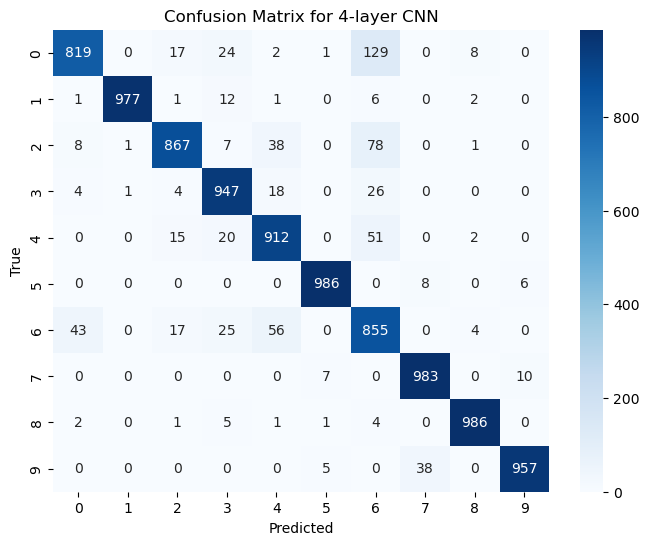

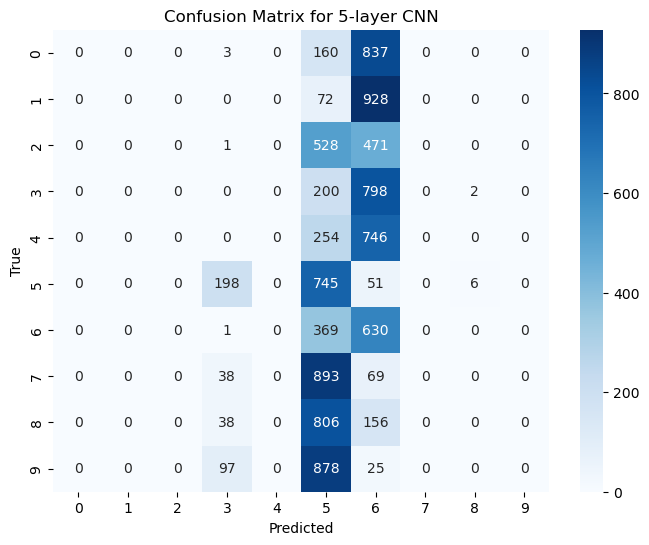

In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# True labels and predicted labels for model_layer
y_true_model_layer = y_test  # Replace with your true labels for model_layer
y_pred_model_layer = model_layer.predict(X_test)  # Predicted probabilities; adjust as needed

# True labels and predicted labels for model_5layer
y_true_model_5layer = y_test  # Replace with your true labels for model_5layer
y_pred_model_5layer = model_5layer.predict(X_test)  # Predicted probabilities; adjust as needed

# Convert predicted probabilities to class labels
y_pred_class_model_layer = np.argmax(y_pred_model_layer, axis=1)
y_pred_class_model_5layer = np.argmax(y_pred_model_5layer, axis=1)



# Calculate precision, recall, and F1 score for model_layer
precision_model_layer = precision_score(y_true_model_layer, y_pred_class_model_layer, average='micro')
recall_model_layer = recall_score(y_true_model_layer, y_pred_class_model_layer, average='micro')
f1_model_layer = f1_score(y_true_model_layer, y_pred_class_model_layer, average='micro')

# Calculate precision, recall, and F1 score for model_5layer
precision_model_5layer = precision_score(y_true_model_5layer, y_pred_class_model_5layer, average='micro')
recall_model_5layer = recall_score(y_true_model_5layer, y_pred_class_model_5layer, average='micro')
f1_model_5layer = f1_score(y_true_model_5layer, y_pred_class_model_5layer, average='micro')

# Print precision, recall, and F1 score for model_layer
print("Metrics for 4-layer:")
print(f"Precision: {precision_model_layer:.4f}")
print(f"Recall: {recall_model_layer:.4f}")
print(f"F1 Score: {f1_model_layer:.4f}")

# Print precision, recall, and F1 score for model_5layer
print("Metrics for 5-layer:")
print(f"Precision: {precision_model_5layer:.4f}")
print(f"Recall: {recall_model_5layer:.4f}")
print(f"F1 Score: {f1_model_5layer:.4f}")


from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix for model_layer
cm_model_layer = confusion_matrix(y_true_model_layer, y_pred_class_model_layer)

# Calculate confusion matrix for model_5layer
cm_model_5layer = confusion_matrix(y_true_model_5layer, y_pred_class_model_5layer)

# Plot confusion matrix for model_layer
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_layer, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 4-layer CNN')
plt.show()

# Plot confusion matrix for model_5layer
plt.figure(figsize=(8, 6))
sns.heatmap(cm_model_5layer, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 5-layer CNN')
plt.show()

In [ ]:
# Plot confusion matrix for model_layer
plt.figure(figsize=(10, 6))
sns.heatmap(cm_model_layer, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 4-layer CNN')

# Print precision, recall, and F1 score for model_layer
plt.text(11, -1, "Metrics for 4-layer:", fontsize=12, color="black")
plt.text(11, -2, f"Precision: {precision_model_layer:.4f}", fontsize=10, color="black")
plt.text(11, -3, f"Recall: {recall_model_layer:.4f}", fontsize=10, color="black")
plt.text(11, -4, f"F1 Score: {f1_model_layer:.4f}", fontsize=10, color="black")

plt.show()

# Plot confusion matrix for model_5layer
plt.figure(figsize=(10, 6))
sns.heatmap(cm_model_5layer, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 5-layer CNN')

# Print precision, recall, and F1 score for model_5layer
plt.text(11, -1, "Metrics for 5-layer:", fontsize=12, color="black")
plt.text(11, -2, f"Precision: {precision_model_5layer:.4f}", fontsize=10, color="black")
plt.text(11, -3, f"Recall: {recall_model_5layer:.4f}", fontsize=10, color="black")
plt.text(11, -4, f"F1 Score: {f1_model_5layer:.4f}", fontsize=10, color="black")

plt.show()


In [ ]:
# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot confusion matrix for model_layer
sns.heatmap(cm_model_layer, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10), ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for 4-layer CNN')

# Print precision, recall, and F1 score for model_layer
metrics_text_4layer = f"Metrics for 4-layer:\nPrecision: {precision_model_layer:.4f}\nRecall: {recall_model_layer:.4f}\nF1 Score: {f1_model_layer:.4f}"
axs[0].text(11, -1, metrics_text_4layer, fontsize=12, color="black")

# Plot confusion matrix for model_5layer
sns.heatmap(cm_model_5layer, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10), ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for 5-layer CNN')

# Print precision, recall, and F1 score for model_5layer
metrics_text_5layer = f"Metrics for 5-layer:\nPrecision: {precision_model_5layer:.4f}\nRecall: {recall_model_5layer:.4f}\nF1 Score: {f1_model_5layer:.4f}"
axs[1].text(11, -1, metrics_text_5layer, fontsize=12, color="black")

plt.tight_layout()
plt.show()
